Teste com utilização de projetor gama para identificar todas as estrelas na imagem

Uso de find_peaks para identificar os picos de luminosidade nas imagens

Proeminência de 1% do valor máximo

projetor gama = mapa de correlação resultante da iteração dos paramêtros Ks e desvio padrão dentro do espaço de pesquisa definido

- Imagem: 120x120

- Scale: 0.4

- Origem: skyserver dr18

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV para carregar a imagem
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import find_peaks 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Caminho para a imagem

image_path = r"data\sdss\sdss_image_180.316130449752_-0.0240209645983516.jpg"


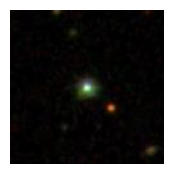

In [3]:
# Carregar a imagem
img_input = mpimg.imread(image_path)

# Criar uma nova figura
plt.figure(figsize=(2, 2))  # O argumento figsize define o tamanho da figura

# Exibir a imagem
plt.imshow(img_input)

# Remover os eixos (opcional)
plt.axis('off')

# Mostrar a figura
plt.show()

## Reader

In [4]:
# Abrir a imagem e converter para escala de cinza
reader_input = Image.open(image_path).convert('L')
reader_output = np.array(reader_input)

# Print da imagem em array
print(reader_output)


[[9 8 8 ... 4 4 5]
 [7 7 6 ... 1 2 3]
 [4 4 4 ... 1 3 4]
 ...
 [7 4 1 ... 1 1 2]
 [2 0 0 ... 0 1 3]
 [0 0 0 ... 0 1 4]]


## Preprocessing

In [5]:
# Preprocessamento: subtrair a média para suavizar
img_avg = reader_output - reader_output.mean()

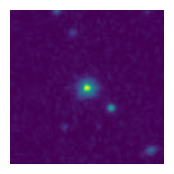

In [6]:
# Criar uma nova figura
plt.figure(figsize=(2, 2))  # O argumento figsize define o tamanho da figura

# Exibir a imagem
plt.imshow(img_avg)

# Remover os eixos (opcional)
plt.axis('off')

# Mostrar a figura
plt.show()

## Model

In [7]:
# Função para gerar o kernel gaussiano
def gaussian_kernel(KSize, sigma):
    kernel = np.zeros((KSize, KSize))
    center = KSize // 2
    for i in range(KSize):
        for j in range(KSize):
            kernel[i, j] = (1 / (2 * np.pi * sigma ** 2)) * \
                           np.exp(-((i - center) ** 2 + (j - center) ** 2) / (2 * sigma ** 2))
    return kernel

# Função para gerar o mapa de correlação
def correlation_map(image, KSize, sigma):
    kernel = gaussian_kernel(KSize, sigma)
    M, N = image.shape
    corr_map = np.zeros((M - KSize + 1, N - KSize + 1))
    for x in range(M - KSize + 1):
        for y in range(N - KSize + 1):
            region = image[x:x + KSize, y:y + KSize]
            corr_map[x, y] = np.sum(region * kernel)
    return corr_map

# Função para gerar o projetor gama
def gamma_projector(image):
    M, N = image.shape
    gamma_map = np.zeros((M, N))
    for K_s in range(3, min(M, N), 2):
        for sigma in range(1, int(2 * K_s + 3)):
            corr_map = correlation_map(image, K_s, sigma)
            padded_corr_map = np.pad(corr_map, ((K_s//2, K_s//2), (K_s//2, K_s//2)), mode='constant')
            gamma_map += padded_corr_map[:M, :N]
    return gamma_map


In [8]:
star_positions = gamma_projector(img_avg)

star_positions

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.81814712,   0.31354396, ...,  -5.73909231,
         -4.27579145,   0.        ],
       [  0.        ,  -2.35155136,  -7.05473516, ..., -15.4031829 ,
         -3.85839685,   0.        ],
       ...,
       [  0.        ,  -2.52584919, -14.30345996, ..., -18.14697037,
         -6.61070074,   0.        ],
       [  0.        ,  -6.41799329,  -7.81249521, ...,  -7.63819738,
         -6.47994755,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

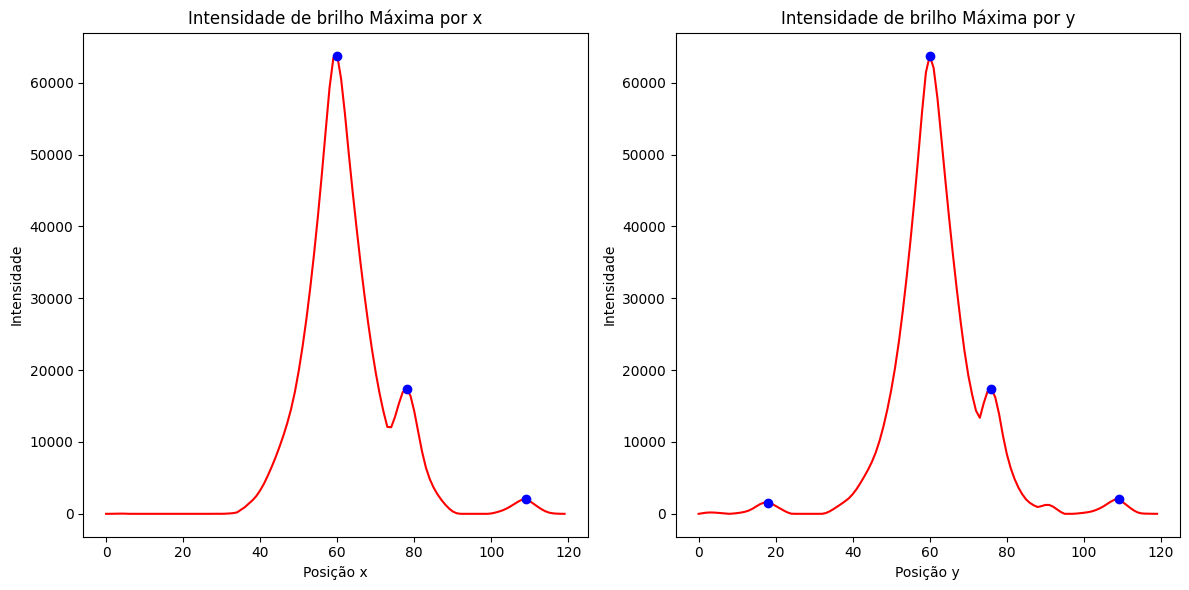

Pares de picos encontrados: [(60, 60), (60, 76), (78, 60), (78, 76), (109, 109)]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Obter a intensidade ao longo das dimensões x e y
intensity = np.stack(star_positions, axis=0)

# Encontrar o maior valor ao longo da dimensão y para cada x
max_by_x = intensity.max(axis=0)  # Máximo ao longo da dimensão y

# Encontrar o maior valor ao longo da dimensão x para cada y
max_by_y = intensity.max(axis=1)  # Máximo ao longo da dimensão x

# Obter os valores de x e y
x_values = np.arange(intensity.shape[1])
y_values = np.arange(intensity.shape[0])

# Encontrar picos para a curva de intensidade por x
prominence_x = 0.01 * max(max_by_x)  # Proeminência de 1% do valor máximo observado
peaks_x, _ = find_peaks(max_by_x, prominence=prominence_x)

# Encontrar picos para a curva de intensidade por y
prominence_y = 0.01 * max(max_by_y)  # Proeminência de 1% do valor máximo observado
peaks_y, _ = find_peaks(max_by_y, prominence=prominence_y)

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Plotar a curva de intensidade por x
plt.subplot(1, 2, 1)
plt.plot(x_values, max_by_x, color='red')
plt.plot(x_values[peaks_x], max_by_x[peaks_x], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por x')
plt.xlabel('Posição x')
plt.ylabel('Intensidade')

# Plotar a curva de intensidade por y
plt.subplot(1, 2, 2)
plt.plot(y_values, max_by_y, color='red')
plt.plot(y_values[peaks_y], max_by_y[peaks_y], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por y')
plt.xlabel('Posição y')
plt.ylabel('Intensidade')

plt.tight_layout()
plt.show()

# Verificar pares de picos potencialmente repetidos
pares_picos = []
for px in peaks_x:
    for py in peaks_y:
        if intensity[py, px] > prominence_y:  # Verifique se a intensidade no par é maior que o limiar
            pares_picos.append((x_values[px], y_values[py]))

# Exibir os pares de picos encontrados
print("Pares de picos encontrados:", pares_picos)


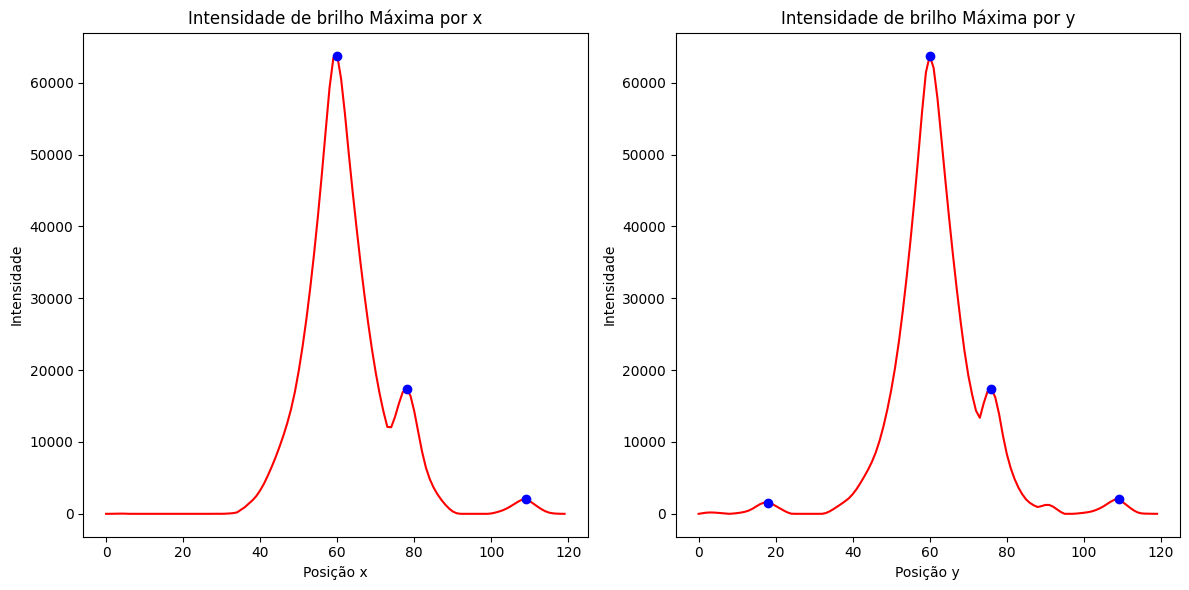

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Exemplo de matriz de intensidade simulada
intensity = np.stack(star_positions, axis=0)

# Encontrar o maior valor ao longo da dimensão y para cada x
max_by_x = intensity.max(axis=0)  # Máximo ao longo da dimensão y

# Encontrar o maior valor ao longo da dimensão x para cada y
max_by_y = intensity.max(axis=1)  # Máximo ao longo da dimensão x

# Obter os valores de x e y
x_values = np.arange(intensity.shape[1])
y_values = np.arange(intensity.shape[0])

# Encontrar picos para a curva de intensidade por x
prominence_x = 0.01 * max(max_by_x)  # Proeminência de 1% do valor máximo observado
peaks_x, _ = find_peaks(max_by_x, prominence=prominence_x)

# Encontrar picos para a curva de intensidade por y
prominence_y = 0.01 * max(max_by_y)  # Proeminência de 1% do valor máximo observado
peaks_y, _ = find_peaks(max_by_y, prominence=prominence_y)

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Plotar a curva de intensidade por x
plt.subplot(1, 2, 1)
plt.plot(x_values, max_by_x, color='red')
plt.plot(x_values[peaks_x], max_by_x[peaks_x], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por x')
plt.xlabel('Posição x')
plt.ylabel('Intensidade')

# Plotar a curva de intensidade por y
plt.subplot(1, 2, 2)
plt.plot(y_values, max_by_y, color='red')
plt.plot(y_values[peaks_y], max_by_y[peaks_y], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por y')
plt.xlabel('Posição y')
plt.ylabel('Intensidade')

plt.tight_layout()
plt.show()


In [11]:
# Verificar pares de picos validos
pares_picos = []
threshold = 0.9  # Limite de 90% do valor máximo para considerar como um ponto válido

# Combinação dos picos detectados nos eixos x e y
# Para cada pico em x, verificamos a intensidade máxima ao longo do eixo y correspondente
for px in peaks_x:
    for py in peaks_y:
        if intensity[py, px] >= threshold * max(max_by_x[px], max_by_y[py]):
            pares_picos.append((x_values[px], y_values[py]))
pares_picos

[(60, 60), (78, 76), (109, 109)]

## Results

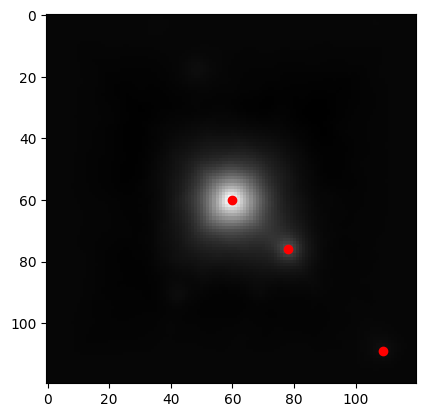

In [12]:
# Exemplo de visualização da imagem com os picos
plt.imshow(intensity, cmap='gray')
for (x, y) in pares_picos:
    plt.scatter([x], [y], color='red')
plt.show()

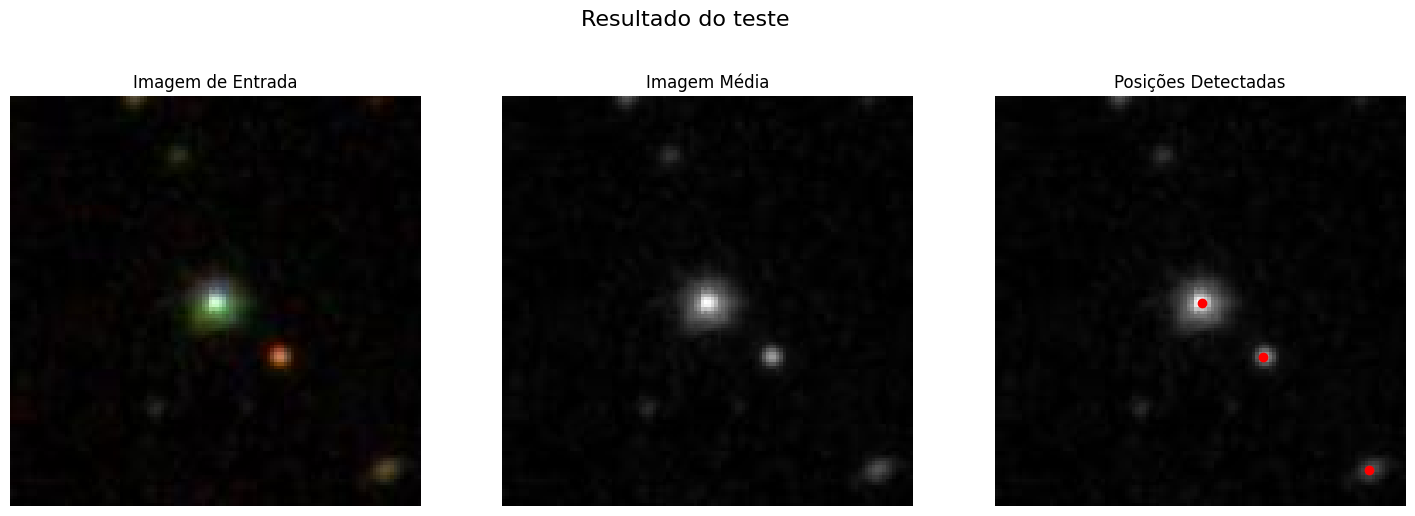

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_input, cmap='gray')
axes[0].set_title('Imagem de Entrada')
axes[0].axis('off')  # Remover os eixos

axes[1].imshow(img_avg, cmap='gray')
axes[1].set_title('Imagem Média')
axes[1].axis('off')

axes[2].imshow(img_avg, cmap='gray')
for (x, y) in pares_picos:
    axes[2].scatter([x], [y], color='red')
axes[2].set_title('Posições Detectadas')
axes[2].axis('off')

# Adicionar um título geral para a figura
fig.suptitle('Resultado do teste', fontsize=16)

plt.show()
